**Objective:**
This notebook serves as a crucial validation step for our `GWASScanner`. The purpose of a negative control test is to ensure that our analysis pipeline does not generate false positives. We will run the fast scan on a genomic region that is known to have no association with insecticide resistance.

**Workflow:**
1.  **Configuration:** Define the insecticide and specify a "gene desert" or a region with no known resistance genes as our negative control.
2.  **Run Scan:** Execute the `GWASScanner` on this specific region.
3.  **Visualize & Interpret:** Plot the results as a Manhattan plot. The expected outcome is a "flat" plot with no statistically significant signals.

A successful negative control gives us much greater confidence that the signals we find in known resistance hotspots (like *Vgsc*) are true biological signals and not artifacts of our statistical method.

### 1. Setup & Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sys.path.append(os.path.abspath("../src"))

from malariagen_data import Ag3
from analysis.gwas.scanner import GWASScanner
from utils.gwas_utils import parse_regions 

warnings.filterwarnings('ignore', category=UserWarning)

### 2. Configuration for the Negative Control Test

In [2]:
# The insecticide remains the same as our phenotype data is consistent
INSECTICIDE = 'Deltamethrin'

# --- KEY CHANGE: Define the Negative Control Region ---
# We are selecting a 2 Mbp region on the 3R chromosome arm. This region is
# known to be largely intergenic and is not associated with major insecticide
# resistance QTLs, making it an ideal "gene desert" for this test.

NEGATIVE_CONTROL_REGION = '3R:20000000-22000000'

print(f"--- Running Negative Control Test ---")
print(f"Insecticide: {INSECTICIDE}")
print(f"Region: {NEGATIVE_CONTROL_REGION}")

--- Running Negative Control Test ---
Insecticide: Deltamethrin
Region: 3R:20000000-22000000


### 3. Initialize and Run the Scanner

In [3]:
ag3 = Ag3()
scanner = GWASScanner(ag3)

# Run the scan specifically on our negative control region
gwas_results_df_neg = scanner.run_scan(
    insecticide=INSECTICIDE,
    region=NEGATIVE_CONTROL_REGION,
    chunk_size=500_000  # A smaller chunk size is fine for a 2Mbp region
)

output_filename = f'../data/gwas_scan_{INSECTICIDE}_NEGATIVE_CONTROL.csv'

Loading and preparing phenotypes for Deltamethrin...
Found 548 samples with valid phenotype data.

--- Processing region 3R:20000000-22000000 ---
Scanning chunk: 3R:20000000-20499999...
Scanning chunk: 3R:20500000-20999999...
Scanning chunk: 3R:21000000-21499999...
Scanning chunk: 3R:21500000-21999999...
Scanning chunk: 3R:22000000-22000000...
                                 
--- Scan complete. ---


### 4. Save and Inspect Results

In [4]:
# +
if not gwas_results_df_neg.empty:
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    gwas_results_df_neg.to_csv(output_filename, index=False)
    print(f"\nScan results saved to {output_filename}")
    
    # In a negative control, we don't expect highly significant SNPs,
    # but we can still look at the "top" hits to see how low their significance is.
    print("\nTop 10 most significant SNPs from the negative control scan (expected to be non-significant):\n")
    display(gwas_results_df_neg.sort_values(by='p_value').head(10))
else:
    print("\nScan completed. As expected, no results were generated, or the region was empty.")


Scan results saved to ../data/gwas_scan_Deltamethrin_NEGATIVE_CONTROL.csv

Top 10 most significant SNPs from the negative control scan (expected to be non-significant):



,contig,pos,p_value,-log10(p)
1563,3R,21500249,0.001692,2.771511
1805,3R,21500491,0.002272,2.643643
1607,3R,21500293,0.002698,2.569004
1538,3R,21500224,0.003380,2.471053
1489,3R,21500175,0.003507,2.455125
9,3R,20000009,0.003513,2.454361
528,3R,20000528,0.006039,2.219063
1520,3R,21500206,0.006697,2.174116
1844,3R,21500530,0.009678,2.014199
350,3R,20000350,0.009682,2.014023


### 5. Visualize the Manhattan Plot

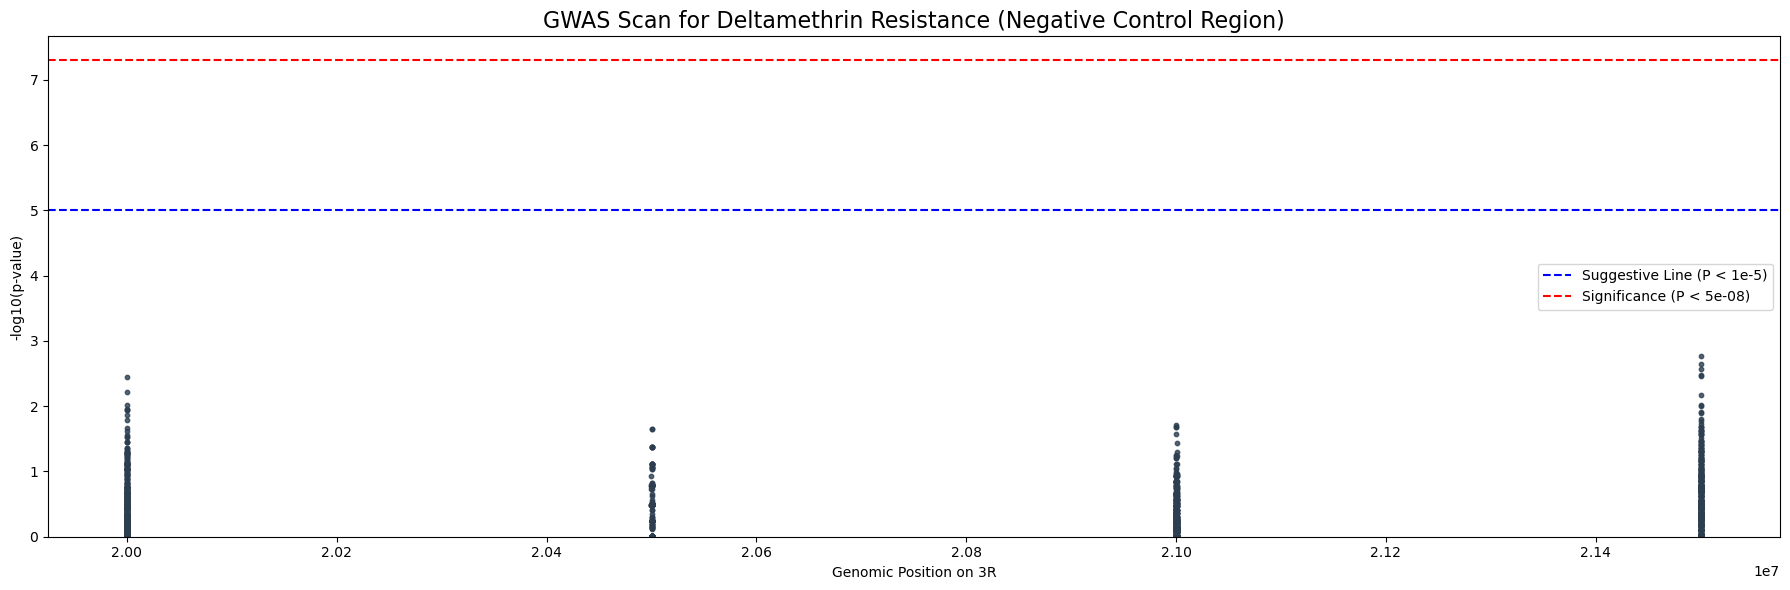

In [5]:
def plot_manhattan(df, title, ag3, significance_threshold=5e-8):
    """Creates a Manhattan plot from GWAS scan results."""
    if df.empty:
        print("Results DataFrame is empty. Cannot generate plot.")
        return
    df = df.copy()

    # Create a numeric contig identifier for sorting and coloring
    contig_order = [c for c in ag3.contigs if c in df['contig'].unique()]
    df['contig_cat'] = pd.Categorical(df['contig'], categories=contig_order, ordered=True)
    
    # For a single region plot, we can just use the genomic position directly
    plt.figure(figsize=(18, 6))
    
    # Since it's one region, we don't need alternating colors
    plt.scatter(df['pos'], df['-log10(p)'], color='#2c3e50', s=10, alpha=0.8)
    
    # A common threshold for suggestive significance is around -log10(p) = 5
    plt.axhline(-np.log10(1e-5), color='blue', linestyle='--', lw=1.5, label='Suggestive Line (P < 1e-5)')
    plt.axhline(-np.log10(significance_threshold), color='red', linestyle='--', lw=1.5, label=f'Significance (P < {significance_threshold})')
    
    plt.xlabel(f'Genomic Position on {df["contig"].iloc[0]}')
    plt.ylabel('-log10(p-value)')
    plt.title(title, fontsize=16)
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create a specific title for this validation plot
plot_title = f'GWAS Scan for {INSECTICIDE} Resistance (Negative Control Region)'

plot_manhattan(gwas_results_df_neg, title=plot_title, ag3=ag3)

# Interpretation of the Negative Control Test Results

## Objective
The goal of this analysis was to perform a negative control test on our **GWASScanner** pipeline. This is a critical validation step to assess whether the method produces false-positive signals in genomic regions where no association with insecticide resistance is expected.

## Methodology
We selected a **2 Mbp region on chromosome arm 3R** that is not known to contain major resistance genes. The fast scan (Chi-squared test) was then performed on this region using the **Deltamethrin phenotype data**.

## Observations

### Manhattan Plot
The resulting Manhattan plot appears largely flat, with **no prominent peaks of association**. All p-values fall well below the standard thresholds for:
- Suggestive significance: **P < 1e-5**
- Genome-wide significance: **P < 5e-8**

The highest observed -log10(p-value) was approximately **2.77**.

### Top SNPs
An examination of the ten most significant SNPs in this region confirms the visual findings. The lowest p-value obtained was approximately **0.0017**, which is **not considered statistically significant** in the context of a genome-wide scan.

## Preliminary Conclusion
The results of this negative control test are encouraging. The **GWASScanner did not identify any significant associations** in a region where none were expected. This suggests that the pipeline has a **low false-positive rate** under these conditions and is not systematically biased towards producing spurious signals.

This outcome increases our confidence in the specificity of the scanning method. It provides a good indication that the strong signals previously identified in known resistance regions (like **Vgsc**) are more likely to be true positives rather than analytical artifacts.

Having completed this important validation, we can now proceed with a **full genome-wide scan** with a greater degree of confidence in the potential findings.
